In [12]:
import glob
import segyio
import segysak
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm
from devito import configuration, VectorTimeFunction, TensorTimeFunction
from examples.seismic import AcquisitionGeometry
from examples.seismic.elastic import ElasticWaveSolver
from scratch.util import CreateSeismicModel, nn_interp_coords, plot_rec_src       

In [2]:
configuration['ignore-unknowns'] = True

In [3]:
#Закоменти, чтобы выполнять на CPU
from devito import configuration

#(a) using one GPU
#(b) using multi-GPUs with MPI (requires turning the notebook into a python script)
configuration['platform'] = 'nvidiaX'
configuration['compiler'] = 'pgcc'
configuration['language'] = 'openacc'

In [4]:
sc_path = 'Modeling_data/2D_Scenarios'
scenarios = glob.glob(sc_path+'/sc*')

df_ins = pd.read_csv(sc_path+'/instruments.txt', sep='\t')
df_ins['Z'] += 2
# df_ins['X'] = np.linspace(0,7950, 319)

constraints = {"Vp": 1800, "Vs": 750, "Rho" : 1500}

In [5]:
for i, scenario in enumerate(scenarios[1:]): #single check
# for i, scenario in enumerate(scenarios): #whole
    readsgy = lambda x : xr.open_dataset(x,
                                         dim_byte_fields={"cdp" : 1},
                                         extra_byte_fields={'cdp_x':181, 'cdp_y':185}
                                        )
    el_pars = {file.split('/')[-1].split(' ')[0] : readsgy(file) for file in glob.glob(scenario+'/*.sgy')}
    # plot_hist_pars(el_pars, ignore_zero=True) # гистограммы параметров перед корректировкой
    for k, v in el_pars.items():
        el_pars[k] = el_pars[k].where(((el_pars[k] > constraints[k]) | (el_pars[k].samples>100) | (el_pars[k] == 0)), constraints[k])
    # plot_hist_pars(el_pars, ignore_zero=True)  # гистограммы параметров после корректировки

    # привычный формат
    rho_data = (el_pars["Rho"].data/1000).to_numpy()
    vp_data = (el_pars["Vp"].data/1000).to_numpy()
    vs_data = (el_pars["Vs"].data/1000).to_numpy()

    # Верхний слой со свойствами воды
    rho_data[rho_data==0] = 1.
    vp_data[vp_data==0] = 1.5
    vs_data[vs_data==0] = 0.0

    # сетка
    dim_vectors = ((el_pars['Rho'].cdp.data-1)*25, (el_pars['Rho'].samples.data))
    spacing = (2.5, 2.5) # z из header_rho.loc["TRACE_SAMPLE_INTERVAL", "mean"]
    origin = (0, 0)
    nbl = 40
    so = 8
    
    # инт данные
    rho_data_int = nn_interp_coords(rho_data, origin, (7950, 1000), spacing, dim_vectors)
    vp_data_int = nn_interp_coords(vp_data, origin, (7950, 1000), spacing, dim_vectors)
    vs_data_int = nn_interp_coords(vs_data, origin, (7950, 1000), spacing, dim_vectors)

    # модель
    model = CreateSeismicModel(origin=origin,
                           spacing=spacing,
                           shape=vp_data_int.shape,
                           vp=vp_data_int,
                           vs=vs_data_int,
                           rho=rho_data_int,
                           so=so,
                           nbl=nbl,
                           bcs='mask',
                          )
    
    # геометрия
    t0=0.
    tn=1000.
    f0=0.025

    # nsrc = 2
    # src_coordinates = np.empty((nsrc, 2))
    # src_coordinates[:] = ((df_ins['X'][159], 0), (df_ins['X'][100], 0))
    
    nsrc = df_ins.loc[(df_ins['X']>1000) & (df_ins['X']<7100)]['X'].shape[0]
    src_coordinates = np.empty((nsrc, 2))
    src_coordinates[:, 0] = df_ins.loc[(df_ins['X']>1000) & (df_ins['X']<7100)]['X']
    src_coordinates[:, 1] = df_ins.loc[(df_ins['X']>1000) & (df_ins['X']<7100)]['Z']
    src_coordinates = src_coordinates[20:24, :]

    nrec = df_ins.shape[0]
    rec_coordinates = np.empty((nrec, 2))
    rec_coordinates[:,0] = df_ins['X']
    rec_coordinates[:,1] = df_ins['Z'] 
    
    # тензоры
    v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=2)
    tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=2)

    print('Starting operator')
    for i, src_coords in enumerate(tqdm(src_coordinates)):
        print('Source - ', i, '; Coordinate - ', src_coords)
        geometry = AcquisitionGeometry(model, rec_coordinates, src_coords, t0, tn, f0=f0, src_type='Ricker')
        
        # солвер
        solver = ElasticWaveSolver(model, geometry, space_order=so, v=v, tau=tau)
        
        # оператор
        rec_p, rec_v, v, tau, summary = solver.forward()
        
        # выгрузка в sgy
        dt_r = 1
        inheader = segysak.segy.segy_header_scrape(scenarios[1]+'/Vs 2D 1.sgy')
        rec_v = rec_v.resample(dt=dt_r)
        
        segyio.tools.from_array2D(scenario+'/Results/2d_vankor_SRC-'+str(int(src_coords[0]))+'.sgy', rec_v.data.T, dt=dt_r*10**3)
        with segyio.open(scenario+'/Results/2d_vankor_SRC-'+str(int(src_coords[0]))+'.sgy', 'r+') as f:
            for j in range(len(f.header)):
                f.header[j] = {segyio.TraceField.CDP: j,
                               segyio.TraceField.CDP_X: np.array(inheader['CDP_X'][j]*10),
                               segyio.TraceField.CDP_Y: np.array(inheader['CDP_Y'][j]*10),
                               segyio.TraceField.ReceiverGroupElevation: np.array(df_ins['Z'][j], dtype = int),
                               segyio.TraceField.ElevationScalar : 1,
                               segyio.TraceField.SourceGroupScalar : -100,
                               segyio.TraceField.SourceX : int(src_coords[0]*100)
                              }
        #Доделать, чтобы шот отображался еще и в названии

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

Operator `initdamp` ran in 0.07 s


Starting operator


  0%|                                                                                                                 | 0/4 [00:00<?, ?it/s]

Source -  0 ; Coordinate -  [1528.5   64. ]


Operator `ForwardElastic` ran in 1.15 s


  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

/home/spaceswimmer/Documents/NeoGen_Modeling/.venv/lib/python3.12/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
 25%|██████████████████████████▎                                                                              | 1/4 [00:03<00:11,  3.87s/it]

Source -  1 ; Coordinate -  [1554.75   64.  ]


Operator `ForwardElastic` ran in 1.19 s


  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

/home/spaceswimmer/Documents/NeoGen_Modeling/.venv/lib/python3.12/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
 50%|████████████████████████████████████████████████████▌                                                    | 2/4 [00:07<00:07,  3.83s/it]

Source -  2 ; Coordinate -  [1579.75   64.  ]


Operator `ForwardElastic` ran in 1.17 s


  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

/home/spaceswimmer/Documents/NeoGen_Modeling/.venv/lib/python3.12/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
 75%|██████████████████████████████████████████████████████████████████████████████▊                          | 3/4 [00:11<00:03,  3.84s/it]

Source -  3 ; Coordinate -  [1604.75   66.  ]


Operator `ForwardElastic` ran in 1.15 s


  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

/home/spaceswimmer/Documents/NeoGen_Modeling/.venv/lib/python3.12/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.85s/it]


In [7]:
scenario+'/Results/2d_vankor_SRC-'+str(int(src_coords[0]))+'.sgy'

'Modeling_data/2D_Scenarios/sc_1/Results/2d_vankor_SRC-1604.sgy'

In [8]:
df_ins['X'][100]

np.float64(2547.28)

In [9]:
test = np.array(df_ins.loc[(df_ins['X']>1000) & (df_ins['X']<7100)]['X'])

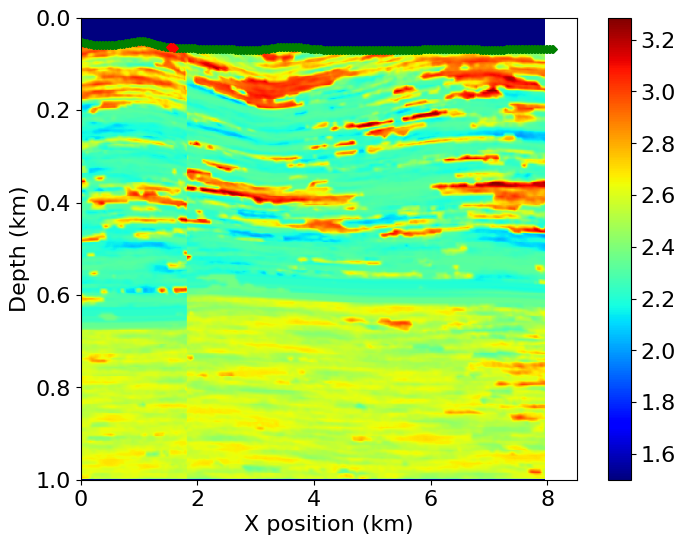

In [13]:
plot_rec_src(model=model, data_type='vp', src_coords=src_coordinates, rec_coords=rec_coordinates)